In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = True
load_gsea = True
load_gsea_heatmap = False
run_umap = False

In [2]:
# Parameters
id_ = "Kim_Lee_2020_LUAD"


# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 204300 × 27613
    obs: 'sample', 'patient', 'Tissue origins', 'histology', 'sex', 'age', 'smoking', 'pathology', 'EGFR', 'tumor_stage', 'geo_accession', 'tissue_orig', 'condition', 'dataset', 'origin', 'tissue', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Types from infercnv dir

In [5]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'barcode_'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,barcode_,cell_type
0,AAACCTGAGAAACCGC_LN_05,Lymphoid
1,AAACCTGAGAAACGCC_NS_13,Alveolar epithelium
2,AAACCTGAGAAGGTGA_LUNG_N18,Lymphoid
3,AAACCTGAGACAAAGG_LUNG_N18,Myeloid
4,AAACCTGAGACATAAC_LN_04,Lymphoid
...,...,...
204295,TTTGTCATCTTGCCGT_LUNG_T30,Alveolar epithelium
204296,TTTGTCATCTTGTATC_EFFUSION_13,Lymphoid
204297,TTTGTCATCTTTACAC_LUNG_N20,Myeloid
204298,TTTGTCATCTTTACAC_LUNG_T25,Lymphoid


In [6]:
adata.obs['barcode_'] = adata.obs.index
adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['sample', 'patient', 'Tissue origins', 'histology', 'sex', 'age',
       'smoking', 'pathology', 'EGFR', 'tumor_stage', 'geo_accession',
       'tissue_orig', 'condition', 'dataset', 'origin', 'tissue', 'n_counts',
       'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'barcode_', 'cell_type'],
      dtype='object')

### Tumor prediction from ikarus

In [7]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Normal
1,1,Normal
2,2,Normal
3,3,Normal
4,4,Normal
...,...,...
204295,204295,Normal
204296,204296,Normal
204297,204297,Normal
204298,204298,Normal


In [8]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [9]:
adata.obs['origin']

0                   normal
1         tumor_metastasis
2          normal_adjacent
3          normal_adjacent
4                   normal
                ...       
204295       tumor_primary
204296            effusion
204297     normal_adjacent
204298       tumor_primary
204299       tumor_primary
Name: origin, Length: 204300, dtype: category
Categories (5, object): ['effusion', 'normal', 'normal_adjacent', 'tumor_metastasis', 'tumor_primary']

In [10]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
tumor_primary      55927
normal_adjacent    42761
normal             37143
Name: count, dtype: int64

In [11]:
adata.layers['counts'] = adata.X

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [13]:
#papermill_description=UMAP
if run_umap:
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

In [14]:
if run_umap:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    sc.pl.umap(
        adata,
        color="cell_type",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="final_pred",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="origin",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="sample",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    # Display the entire figure with all plots
    plt.tight_layout()
    plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [15]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_27811/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
BRONCHO_11     3142
BRONCHO_58     2696
EBUS_06        2185
EBUS_10        4968
EBUS_12        2959
EBUS_13        3443
EBUS_15        1025
EBUS_19        2026
EBUS_28        4873
EBUS_49        1707
EBUS_51        3175
EFFUSION_06    4821
EFFUSION_11    2924
EFFUSION_12    4203
EFFUSION_13    4406
EFFUSION_64    3809
LN_01          3616
LN_02          3159
LN_03          3006
LN_04          3077
LN_05          3085
LN_06          2928
LN_07          5665
LN_08          4360
LN_11          3748
LN_12          4499
LUNG_N01       3175
LUNG_N06       2794
LUNG_N08       3356
LUNG_N09       2498
LUNG_N18       4591
LUNG_N19       3852
LUNG_N20       5797
LUNG_N28       3396
LUNG_N30       3874
LUNG_N31       4230
LUNG_N34       5198
LUNG_T06       3413
LUNG_T08       3728
LUNG_T09       3781
LUNG_T18       3638
LUNG_T19       4326
LUNG_T20       3946
LUNG_T25       4337
LUNG_T28       4538
LUNG_T30       4086
LUNG_T31       5430
LUNG_T34       3243
NS_02          2265
NS_03        

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [16]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if 'normal' in x['origin'] else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0                    Lymphoid_HT_Normal
1         Alveolar epithelium_TT_Normal
2                    Lymphoid_HT_Normal
3                     Myeloid_HT_Normal
4                    Lymphoid_HT_Normal
                      ...              
204295    Alveolar epithelium_TT_Normal
204296               Lymphoid_TT_Normal
204297                Myeloid_HT_Normal
204298               Lymphoid_TT_Normal
204299                Unknown_TT_Normal
Name: type_tissue, Length: 204300, dtype: category
Categories (28, object): ['Airway epithelium_HT_Normal', 'Airway epithelium_TT_Normal', 'Airway epithelium_TT_Tumor', 'Alveolar epithelium_HT_Normal', ..., 'Submucosal Gland_TT_Normal', 'Unknown_HT_Normal', 'Unknown_TT_Normal', 'Unknown_TT_Tumor']

In [17]:
# We dont get them with unique because it saves the NaN's
adata.obs.cell_type = adata.obs.cell_type.astype('category')
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Mesothelium',
       'Myeloid', 'Smooth muscle', 'Submucosal Gland', 'Unknown'],
      dtype='object')

In [18]:
adata.obs['type_tissue'].value_counts()

type_tissue
Lymphoid_TT_Normal               64103
Lymphoid_HT_Normal               53959
Myeloid_TT_Normal                26460
Myeloid_HT_Normal                19156
Alveolar epithelium_TT_Normal     9700
Unknown_TT_Normal                 7683
Airway epithelium_TT_Tumor        5223
Airway epithelium_TT_Normal       4760
Alveolar epithelium_HT_Normal     2525
Unknown_TT_Tumor                  2468
Fibroblast lineage_TT_Normal      1811
Fibroblast lineage_HT_Normal      1509
Blood vessels_HT_Normal           1038
Airway epithelium_HT_Normal       1025
Alveolar epithelium_TT_Tumor       843
Blood vessels_TT_Normal            727
Smooth muscle_TT_Normal            432
Unknown_HT_Normal                  319
Lymphatic EC_HT_Normal             248
Lymphatic EC_TT_Normal              93
Smooth muscle_HT_Normal             86
Mesothelium_TT_Normal               50
Mesothelium_HT_Normal               38
Submucosal Gland_TT_Normal          19
Lymphoid_TT_Tumor                   12
Myeloid_TT_Tu

In [19]:
#papermill_description=WILCOXON_DE
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/all_{id_}.npy'
key = "wilcoxon"

if load_wilcoxon:
    adata.uns[key] = np.load(all_path, allow_pickle='TRUE').item()
else:
    sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = key,
                       groups=valid_types)
    np.save(all_path, adata.uns[key])

for type in types:
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    normal_healthy = type + '_HT_Normal'

    differ_key = f"w_pair_{type}_differ"
    normal_key = f"w_pair_{type}_normal"
    differ_path =  f'{w_folder}/{differ_key}.npy'
    normal_path = f'{w_folder}/{normal_key}.npy'
    if load_wilcoxon:
        # We check for existance  here and not up there because there some datasets with no normal tissue
        if os.path.exists(differ_path):
            adata.uns[differ_key] = np.load(differ_path, allow_pickle='TRUE').item()
        if os.path.exists(normal_path):
            adata.uns[normal_key] = np.load(normal_path, allow_pickle='TRUE').item()
    else:
        if set([tumor_tumor, normal_tumor]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = differ_key,
                                    groups=[tumor_tumor], reference=normal_tumor)
            np.save(differ_path, adata.uns[differ_key])
            
        if set([normal_tumor, normal_healthy]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = normal_key,
                                    groups=[normal_tumor], reference=normal_healthy)
            np.save(normal_path, adata.uns[normal_key])

In [20]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    print(cond_types)
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [21]:
valid_types

['Lymphoid_TT_Normal',
 'Lymphoid_HT_Normal',
 'Myeloid_TT_Normal',
 'Myeloid_HT_Normal',
 'Alveolar epithelium_TT_Normal',
 'Unknown_TT_Normal',
 'Airway epithelium_TT_Tumor',
 'Airway epithelium_TT_Normal',
 'Alveolar epithelium_HT_Normal',
 'Unknown_TT_Tumor',
 'Fibroblast lineage_TT_Normal',
 'Fibroblast lineage_HT_Normal',
 'Blood vessels_HT_Normal',
 'Airway epithelium_HT_Normal',
 'Alveolar epithelium_TT_Tumor',
 'Blood vessels_TT_Normal',
 'Smooth muscle_TT_Normal',
 'Unknown_HT_Normal',
 'Lymphatic EC_HT_Normal',
 'Lymphatic EC_TT_Normal',
 'Smooth muscle_HT_Normal',
 'Mesothelium_TT_Normal',
 'Mesothelium_HT_Normal',
 'Submucosal Gland_TT_Normal',
 'Lymphoid_TT_Tumor',
 'Myeloid_TT_Tumor']

['Airway epithelium_TT_Tumor']
['Airway epithelium_TT_Tumor', 'Airway epithelium_TT_Normal']
['Alveolar epithelium_TT_Tumor']
['Alveolar epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal']
['Blood vessels_TT_Tumor']
['Blood vessels_TT_Tumor', 'Blood vessels_TT_Normal']
['Fibroblast lineage_TT_Tumor']
['Fibroblast lineage_TT_Tumor', 'Fibroblast lineage_TT_Normal']
['Lymphatic EC_TT_Tumor']
['Lymphatic EC_TT_Tumor', 'Lymphatic EC_TT_Normal']
['Lymphoid_TT_Tumor']
['Lymphoid_TT_Tumor', 'Lymphoid_TT_Normal']
['Mesothelium_TT_Tumor']
['Mesothelium_TT_Tumor', 'Mesothelium_TT_Normal']
['Myeloid_TT_Tumor']
['Myeloid_TT_Tumor', 'Myeloid_TT_Normal']
['Smooth muscle_TT_Tumor']
['Smooth muscle_TT_Tumor', 'Smooth muscle_TT_Normal']
['Submucosal Gland_TT_Tumor']
['Submucosal Gland_TT_Tumor', 'Submucosal Gland_TT_Normal']
['Unknown_TT_Tumor']
['Unknown_TT_Tumor', 'Unknown_TT_Normal']


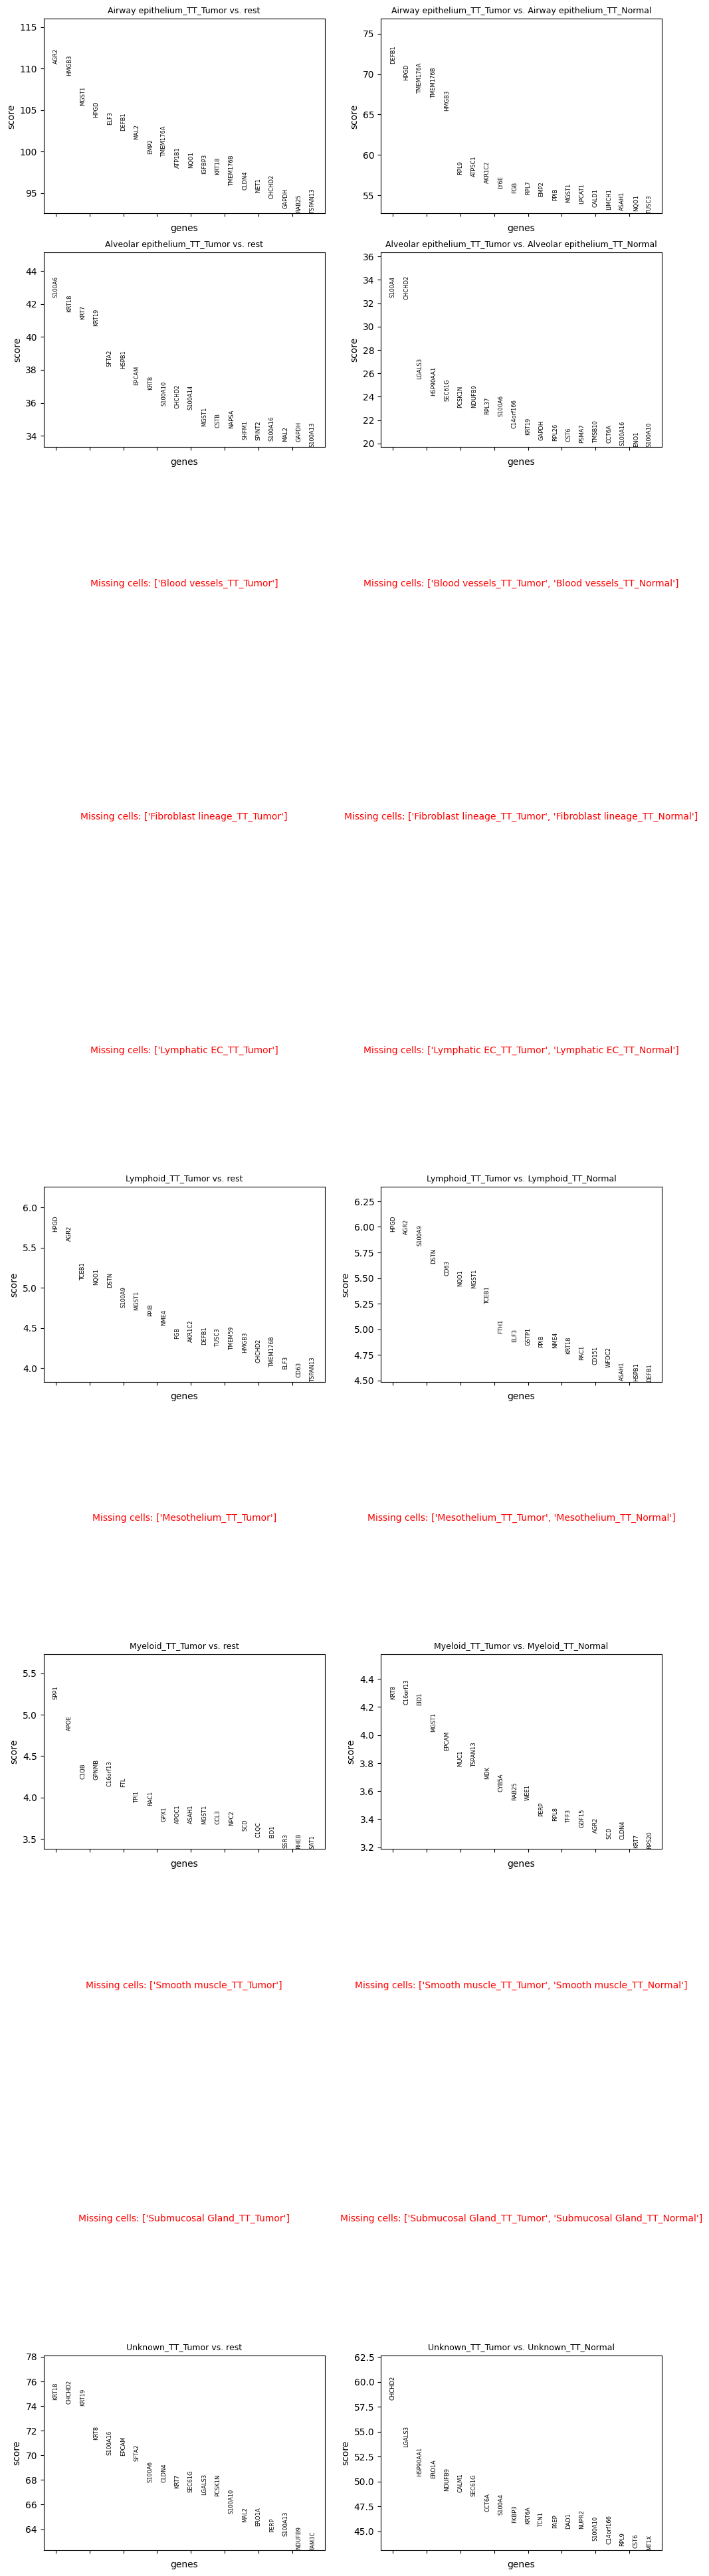

In [22]:
if(adata.obs.origin.str.contains('tumor').any()):
    fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        tumor_tumor = type + '_TT_Tumor'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [tumor_tumor], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
                                key=f"w_pair_{type}_differ", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    from warnings import warn
    warn('NO TUMOR TISSUES!?!?!?!!?')

In [23]:
adata.obs.origin.str.contains('normal').any()

True

['Airway epithelium_HT_Normal']


['Airway epithelium_TT_Normal']
w_pair_Airway epithelium_normal
['Airway epithelium_TT_Normal', 'Airway epithelium_HT_Normal']
['Alveolar epithelium_HT_Normal']


['Alveolar epithelium_TT_Normal']
w_pair_Alveolar epithelium_normal
['Alveolar epithelium_TT_Normal', 'Alveolar epithelium_HT_Normal']
['Blood vessels_HT_Normal']
['Blood vessels_TT_Normal']


w_pair_Blood vessels_normal
['Blood vessels_TT_Normal', 'Blood vessels_HT_Normal']
['Fibroblast lineage_HT_Normal']
['Fibroblast lineage_TT_Normal']
w_pair_Fibroblast lineage_normal
['Fibroblast lineage_TT_Normal', 'Fibroblast lineage_HT_Normal']


['Lymphatic EC_HT_Normal']
['Lymphatic EC_TT_Normal']
w_pair_Lymphatic EC_normal
['Lymphatic EC_TT_Normal', 'Lymphatic EC_HT_Normal']
['Lymphoid_HT_Normal']


['Lymphoid_TT_Normal']
w_pair_Lymphoid_normal
['Lymphoid_TT_Normal', 'Lymphoid_HT_Normal']
['Mesothelium_HT_Normal']


['Mesothelium_TT_Normal']
w_pair_Mesothelium_normal
['Mesothelium_TT_Normal', 'Mesothelium_HT_Normal']
['Myeloid_HT_Normal']
['Myeloid_TT_Normal']
w_pair_Myeloid_normal
['Myeloid_TT_Normal', 'Myeloid_HT_Normal']
['Smooth muscle_HT_Normal']
['Smooth muscle_TT_Normal']
w_pair_Smooth muscle_normal
['Smooth muscle_TT_Normal', 'Smooth muscle_HT_Normal']
['Submucosal Gland_HT_Normal']
['Submucosal Gland_TT_Normal']
w_pair_Submucosal Gland_normal
['Submucosal Gland_TT_Normal', 'Submucosal Gland_HT_Normal']
['Unknown_HT_Normal']
['Unknown_TT_Normal']
w_pair_Unknown_normal
['Unknown_TT_Normal', 'Unknown_HT_Normal']


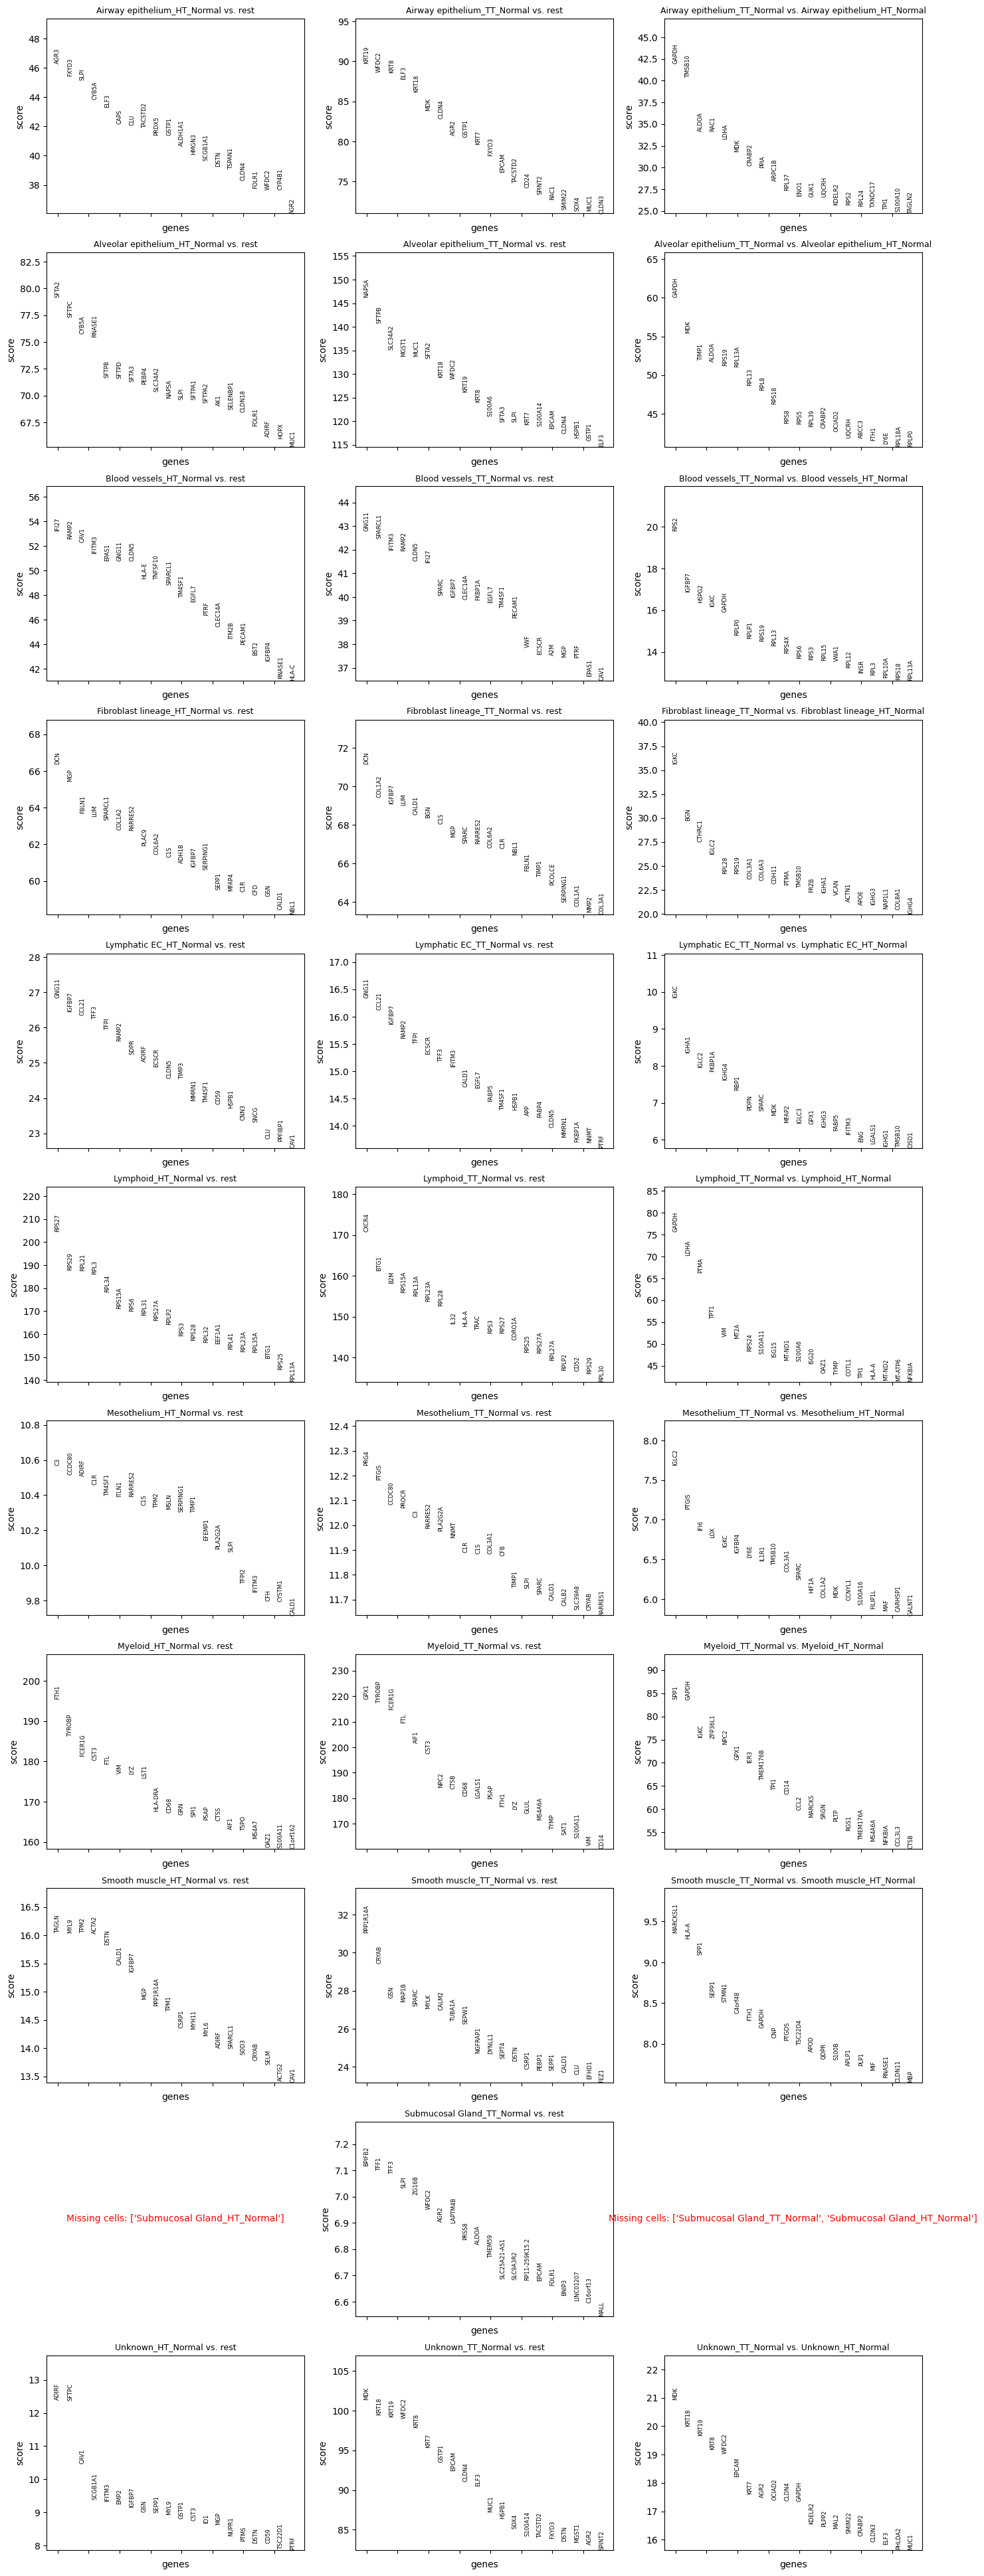

In [24]:
from warnings import warn

if(adata.obs.origin.str.contains('normal').any()):
    fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        normal_healthy = type + '_HT_Normal'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [normal_healthy], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [normal_tumor], valid_types, n_genes=n_genes,
                                ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        print(f"w_pair_{type}_normal")
        cond_plot(adata, [normal_tumor, normal_healthy], valid_types, n_genes=n_genes, ax= axs[i, 2],
                                key=f"w_pair_{type}_normal", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    warn('No healthy tissue!')
    

## Heatmaps

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_HT_Normal, Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, etc.
var_group_labels: Lymphoid_TT_Normal, Lymphoid_HT_Normal, Myeloid_TT_Normal, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


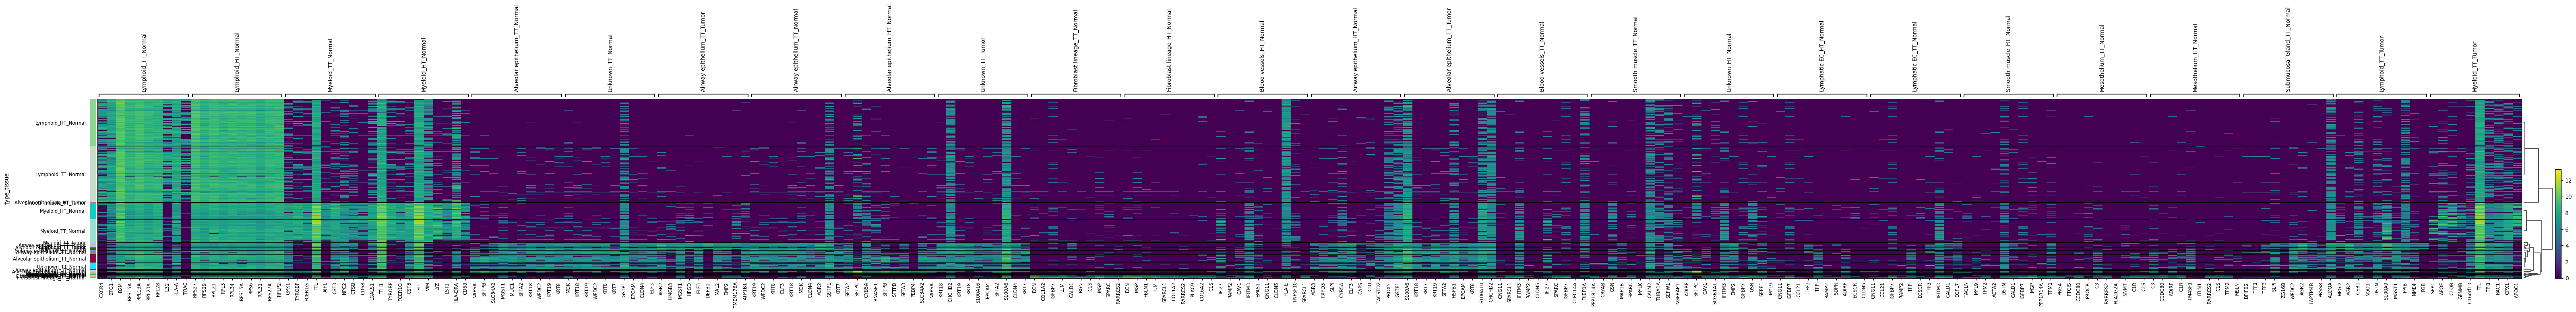

In [25]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [26]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [27]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [28]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [29]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

In [30]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str], types: List[str], id_: str, load_gsea: bool = False) -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)

    gsea_folder = 'gseapy_gsea'
    dfs = []

    for type in types:
        wilco = adata.uns['wilcoxon']
        gsea_path = f'{gsea_folder}/{type}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [31]:
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
gsea_path = f'{gsea_folder}/heatmap_{id_}.csv'

if load_gsea_heatmap:
    combined_df = pd.read_csv(gsea_path, index_col=0)
else:
    types = adata.obs.loc[:, 'type_tissue'].unique()
    combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea=False)
    combined_df.to_csv(gsea_path)

/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:52,280 [WARNING] Duplicated values found in preranked stats: 38.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:53,059 [WARNING] Duplicated values found in preranked stats: 14.29% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:53,782 [WARNING] Duplicated values found in preranked stats: 20.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:54,524 [WARNING] Duplicated values found in preranked stats: 32.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:55,225 [WARNING] Duplicated values found in preranked stats: 47.28% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:56,063 [WARNING] Duplicated values found in preranked stats: 16.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:57,061 [WARNING] Duplicated values found in preranked stats: 13.48% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:57,923 [WARNING] Duplicated values found in preranked stats: 40.26% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:58,750 [WARNING] Duplicated values found in preranked stats: 44.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:59,461 [WARNING] Duplicated values found in preranked stats: 48.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:00,214 [WARNING] Duplicated values found in preranked stats: 14.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:01,120 [WARNING] Duplicated values found in preranked stats: 43.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:01,941 [WARNING] Duplicated values found in preranked stats: 16.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:02,674 [WARNING] Duplicated values found in preranked stats: 26.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:03,427 [WARNING] Duplicated values found in preranked stats: 14.58% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:04,206 [WARNING] Duplicated values found in preranked stats: 30.41% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:04,960 [WARNING] Duplicated values found in preranked stats: 32.81% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:05,714 [WARNING] Duplicated values found in preranked stats: 28.45% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:06,370 [WARNING] Duplicated values found in preranked stats: 21.29% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:07,056 [WARNING] Duplicated values found in preranked stats: 25.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:07,748 [WARNING] Duplicated values found in preranked stats: 22.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:08,390 [WARNING] Duplicated values found in preranked stats: 42.76% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:09,041 [WARNING] Duplicated values found in preranked stats: 16.75% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:09,682 [WARNING] Duplicated values found in preranked stats: 26.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:10,333 [WARNING] Duplicated values found in preranked stats: 31.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27811/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:11,116 [WARNING] Duplicated values found in preranked stats: 37.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [32]:
combined_df

hallmark,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Airway epithelium_HT_Normal,1.164225,-2.095900,1.044660,0.651113,0.747922,0.766730,1.224190,1.252523,1.365240,1.218456,...,1.215730,1.147265,1.369356,1.026166,1.027812,0.872226,1.413091,1.045218,1.086664,1.220525
Airway epithelium_TT_Normal,1.256934,-1.000000,1.186661,0.846245,1.039840,0.983814,1.102230,1.020509,1.298484,1.143971,...,1.404874,1.198354,1.160136,0.976504,0.852606,1.240071,1.153229,1.046300,1.008568,1.210761
Airway epithelium_TT_Tumor,1.241936,-1.000000,1.170300,0.972215,0.988143,1.093703,0.913705,1.020570,1.210347,1.091611,...,1.367413,1.125593,1.100143,0.910634,-1.000000,1.166530,1.206373,0.974238,1.015138,1.267386
Alveolar epithelium_HT_Normal,1.440080,-1.993656,1.352360,0.837152,0.967323,0.775296,1.145813,1.346310,1.539981,1.448314,...,1.280600,1.159515,1.106770,1.192554,1.176175,0.822540,1.430912,1.362345,1.031847,1.477104
Alveolar epithelium_TT_Normal,1.291923,-1.000000,1.153326,0.873926,1.048625,0.961402,1.162306,1.148092,1.221416,1.247988,...,1.387631,1.248211,1.080437,1.132660,0.948798,1.266697,1.226993,1.203524,0.980662,1.271889
Alveolar epithelium_TT_Tumor,1.379404,-1.967366,1.040194,1.082821,1.139421,1.032416,0.955440,0.908476,1.313936,1.278683,...,1.488311,1.249612,1.205376,-0.958984,-1.888497,1.328792,1.000066,0.983497,0.863275,1.402195
Blood vessels_HT_Normal,1.020875,-1.540760,0.920448,1.342676,1.452829,0.971277,1.322235,-1.106717,-0.936626,1.676572,...,0.852368,0.908150,0.710652,1.591325,1.123542,-1.168122,1.558009,1.133627,1.249159,1.085284
Blood vessels_TT_Normal,1.161117,-1.795245,1.136091,1.280998,1.329907,1.122293,1.287840,0.687812,0.963686,1.511696,...,1.269869,1.129004,1.011142,1.472801,1.126367,1.048053,1.435795,1.253102,1.345728,1.139307
Fibroblast lineage_HT_Normal,1.307506,-1.888144,0.895221,1.471830,1.196380,1.169379,1.479206,1.272235,1.214366,1.731216,...,1.348705,1.359251,0.908707,1.353899,1.431151,1.221121,1.682788,1.338882,1.323635,1.454968


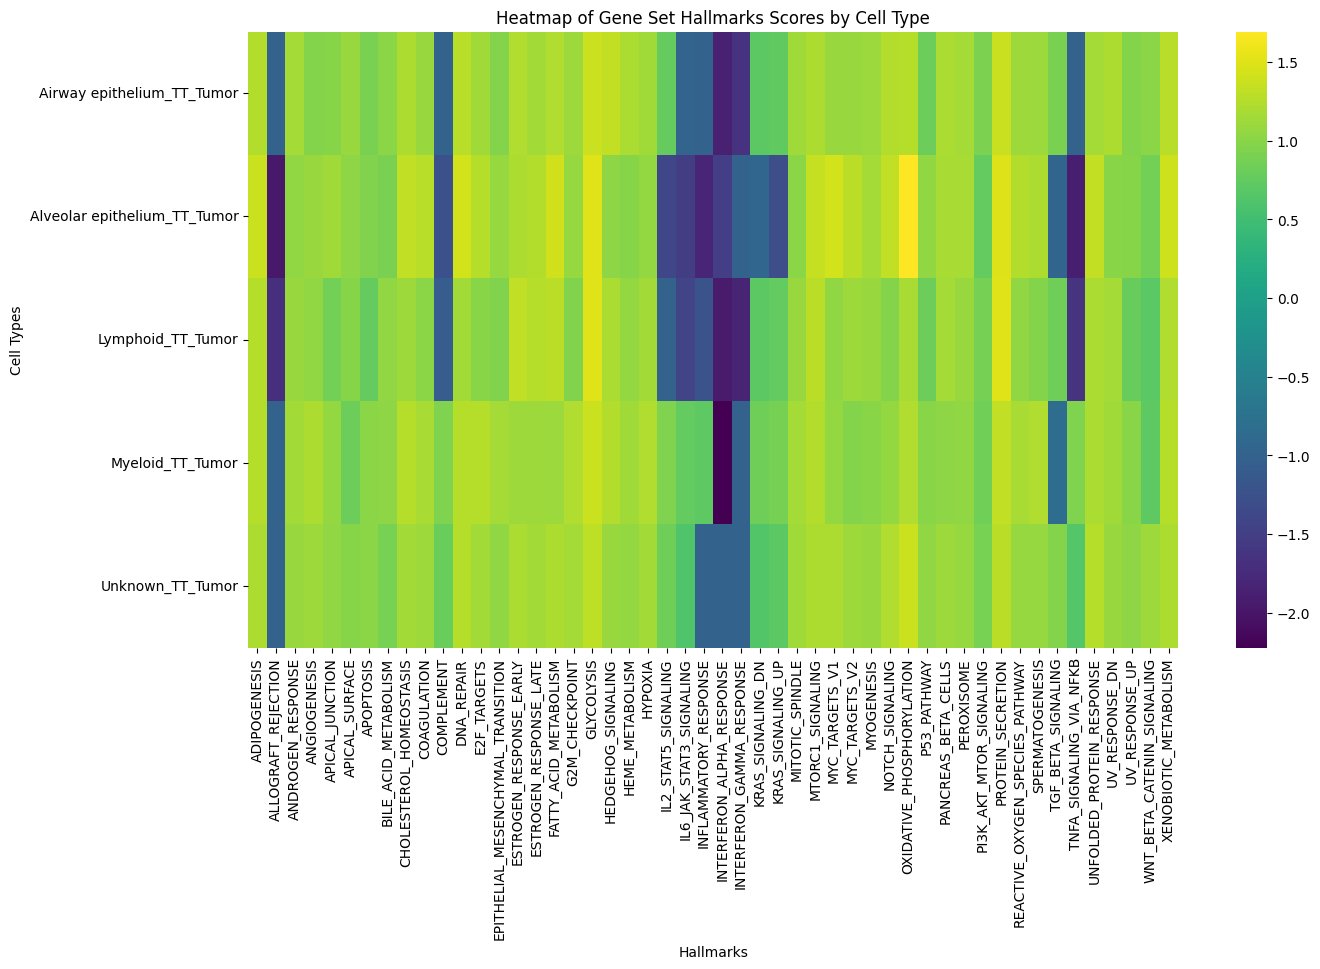

In [33]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df_tumor, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()

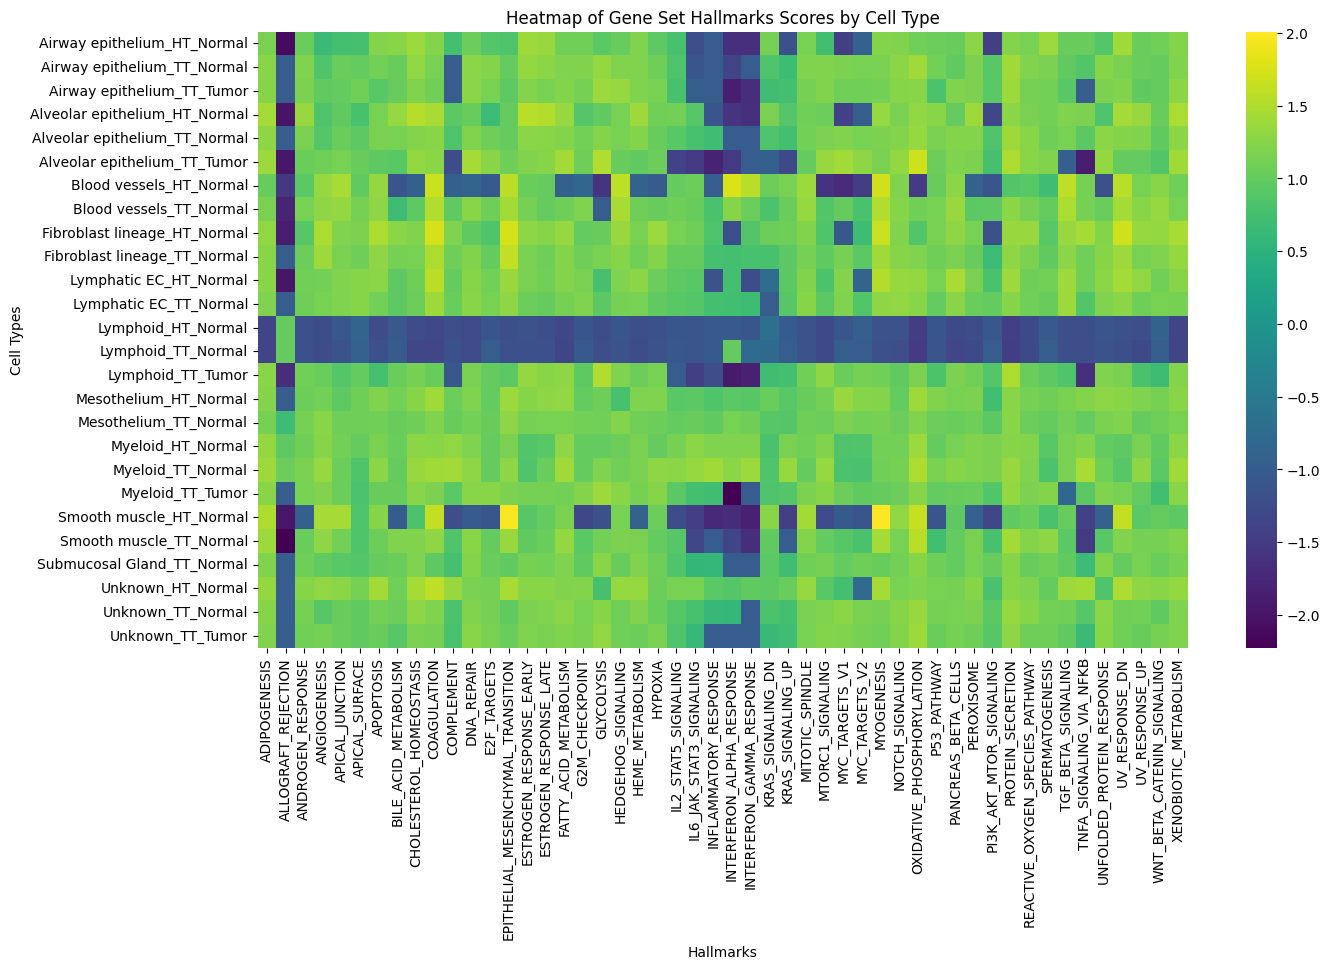

In [34]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Normal']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()